In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import textwrap
import re
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from pprint import pprint
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors


warnings.filterwarnings("ignore")
data_dir = "bbc"

In [2]:
regex = re.compile("[A-Za-z]+")
mystopwords = stopwords.words('english') + ['say','tell','also']

def get_dataset(path):
    data = []
    for root, dirs, files in os.walk(path):
        for name in files:
            file_path = os.path.join(root, name)
            category = file_path.split('\\')[-2]
            text = " ".join(open(file_path, encoding='utf-8', errors = 'ignore').read().splitlines())
            data.append((category,text))
            
    df = pd.DataFrame(data, columns=["category","text"])
    shuffle_df = df.sample(frac = 1, random_state = 42, ignore_index = True)
    return shuffle_df

def words_only(text, regex=regex):
    return [word.lower() for word in regex.findall(text)]

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in mystopwords] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [3]:
df = get_dataset(data_dir)
df.head()

,category,text
0,business,UK house prices dip in November UK house pric...
1,business,LSE 'sets date for takeover deal' The London ...
2,sport,Harinordoquy suffers France axe Number eight ...
3,business,Barclays shares up on merger talk Shares in U...
4,politics,Campaign 'cold calls' questioned Labour and t...


### Препроцессинг

In [4]:
data = df.text.values.tolist()

data_words = [words_only(elem) for elem in data]

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

data = remove_stopwords(data_lemmatized)

### Словарь и корпус

In [5]:
dictionary = corpora.Dictionary(data)
corpus = [dictionary.doc2bow(text) for text in data]

In [6]:
from gensim.models.ldamodel import LdaModel

lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, 
                update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

### Представление по категориям

In [7]:
pprint(lda.print_topics())

[(0,
  '0.013*"year" + 0.013*"win" + 0.011*"good" + 0.010*"film" + 0.009*"play" + '
  '0.007*"go" + 0.007*"game" + 0.007*"first" + 0.007*"get" + 0.007*"take"'),
 (1,
  '0.010*"government" + 0.008*"people" + 0.008*"labour" + 0.008*"party" + '
  '0.006*"election" + 0.006*"make" + 0.005*"new" + 0.005*"plan" + 0.005*"tory" '
  '+ 0.005*"issue"'),
 (2,
  '0.012*"technology" + 0.012*"use" + 0.010*"music" + 0.010*"people" + '
  '0.009*"phone" + 0.009*"mobile" + 0.008*"service" + 0.008*"make" + '
  '0.007*"digital" + 0.006*"company"'),
 (3,
  '0.018*"year" + 0.013*"company" + 0.011*"rise" + 0.010*"market" + '
  '0.008*"firm" + 0.008*"share" + 0.008*"sale" + 0.007*"month" + 0.007*"job" + '
  '0.006*"growth"'),
 (4,
  '0.017*"game" + 0.013*"use" + 0.010*"people" + 0.010*"security" + '
  '0.009*"user" + 0.009*"find" + 0.009*"net" + 0.008*"site" + 0.007*"online" + '
  '0.007*"get"')]


### Интерпретация категорий по модели

In [8]:
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

### Топ слов по категориям

In [9]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  
cloud = WordCloud(stopwords=mystopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)
topic_words = dict(topics)
topic_words

{0: [('year', 0.012975208),
  ('win', 0.012610222),
  ('good', 0.011218637),
  ('film', 0.009582915),
  ('play', 0.009167886),
  ('go', 0.0074986466),
  ('game', 0.007213293),
  ('first', 0.006964038),
  ('get', 0.0067579057),
  ('take', 0.00671988)],
 1: [('government', 0.010084704),
  ('people', 0.008362936),
  ('labour', 0.007912563),
  ('party', 0.007779283),
  ('election', 0.0064975275),
  ('make', 0.006037664),
  ('new', 0.0054860227),
  ('plan', 0.0053671403),
  ('tory', 0.0052586063),
  ('issue', 0.0046327887)],
 2: [('technology', 0.011797269),
  ('use', 0.011574301),
  ('music', 0.010474342),
  ('people', 0.010292787),
  ('phone', 0.009300477),
  ('mobile', 0.009213008),
  ('service', 0.008086038),
  ('make', 0.007838358),
  ('digital', 0.006658708),
  ('company', 0.0063862195)],
 3: [('year', 0.018305218),
  ('company', 0.012605926),
  ('rise', 0.010700793),
  ('market', 0.009774038),
  ('firm', 0.0076531977),
  ('share', 0.0075586084),
  ('sale', 0.007556537),
  ('month', 0

### Визуализация категорий по ключевым словам

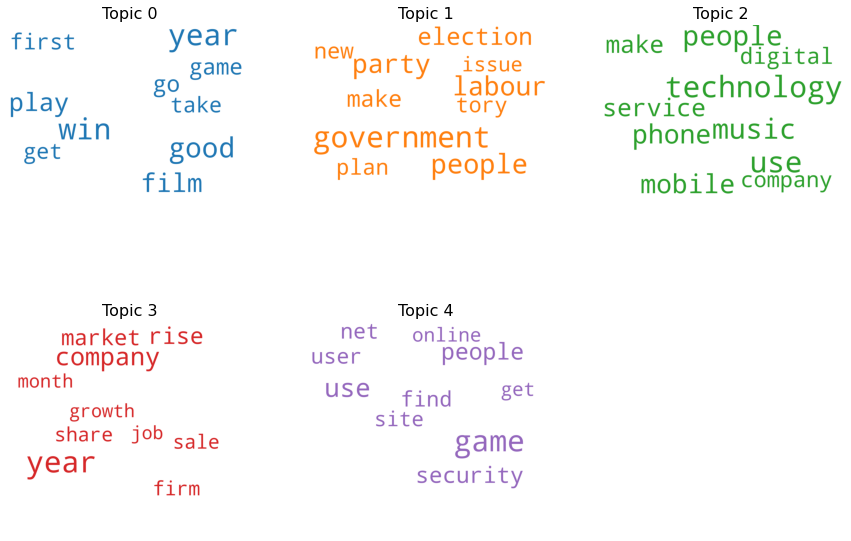

In [10]:
fig, axes = plt.subplots(2,3 , figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    if i!=5:
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')